# Compare Mixing Efficiencies

This code loads a 1D GOTM run, and a 2D Dedalus simulation, and compares the mixing efficiencies.

Note that it is assumed that the two simulations have the same parameters (ie. $\theta$, $N^2$, etc.)

For full analysis of each of these budgets see GOTMEnergetics and EnergyPathways

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from netCDF4 import Dataset

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [9]:
# Load Dedalus Run

#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
visc = 1e-4

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5' #Ruan case F
# visc = 5e-5

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w']

b = f['tasks']['b'] # Perturbation buoyancy


# Energy terms XXX - Need to go clean these up in Dedalus
# gsp = f['tasks']['GSP']
# gspr = f['tasks']['GSProtated']
# vspu = f['tasks']['VSPu']
# vspv = f['tasks']['VSPv']
# vsp = vspu[:,:,:]+vspv[:,:,:]
# lspu = f['tasks']['LSPu']
# lspv = f['tasks']['LSPv']
# lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
dissb = f['tasks']['DISSBPRIME']

# vbf = f['tasks']['VBF']
# vbfr = f['tasks']['VBFr']
# hbfr = f['tasks']['HBFrotated']
# hbfr = hbfr*np.sin(tht[0,0,0])
# vbfrot = f['tasks']['VBFrotated']
# sp = f['tasks']['SP']
# EKE = f['tasks']['EKE']

# # SPECTRAL QUANTITIES
# ws = f['tasks']['wcs']
# bs = f['tasks']['bs']
# vs = f['tasks']['vcs']


# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
# kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

# Calculations
zm = z-z[-1]

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
# up = u - um[:,np.newaxis,:]
# vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(w, axis=-1)/np.gradient(z)
wx = np.gradient(w, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
# EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MKE = 0.5*(um**2 + (vm)**2)
# MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
# MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

bm = np.mean(b, axis=1)
# bmz = np.gradient(bm, axis=-1)/np.gradient(z)
MPE = 0.5*bm**2/N**2

mdiss = -visc*uz**2 - visc*vz**2
WDISS = -visc*np.mean(wz**2 + wx**2, axis=1)
WDISS = 0*WDISS

startind=0
zl = range(0, 256)
DISSIT_d = integrate.cumtrapz(integrate.trapz(mdiss[startind:,zl] + diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MPEI_d = integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)[0]
# EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MIXI_d = integrate.cumtrapz(integrate.trapz(dissb[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
time_d = time

In [10]:
# Load GOTM

filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/GOTMOUTPUTS/gotm_1e-5_0p02.nc' # Ruan et al. 2019 case F
N2 = 1e-5
tht = 0.02

ds =  Dataset(filename, 'r')  # Dataset is the class behavior to open the file

u = np.squeeze(ds.variables['u'])
v = np.squeeze(ds.variables['v'])
b = np.squeeze(ds.variables['buoy'])

SP = np.squeeze(ds.variables['P'])
Pb = np.squeeze(ds.variables['Pb'])
VBP = np.squeeze(ds.variables['G'])
EPS = np.squeeze(ds.variables['eps'])
EPSB = np.squeeze(ds.variables['epsb'])
av = np.squeeze(ds.variables['num'])
taub = np.squeeze(ds.variables['taub'])
drag = np.squeeze(ds.variables['drag'][:,0])
tke = np.squeeze(ds.variables['tke'])
time = ds.variables['time'][:]

z1 = ds.variables['z1'][:][0,:,0,0]
z = ds.variables['z'][:][0,:,0,0]
# bpert = b + N2*(z-z[0])
bpert = b - N2*(z)

MPE = bpert**2/(2*N2)

zl=0
MPEI_g = integrate.trapz(MPE[:,zl:], x=z[zl:], axis=-1)
zl=1
EPSIT_g = integrate.cumtrapz(integrate.trapz(EPS[:,zl:], axis=-1, x=z1[zl:]), x=time[:], initial=0)

EPSBIT_g = integrate.cumtrapz(integrate.trapz(Pb[:,zl:], axis=-1, x=z1[zl:]), x=time[:], initial=0) # see GOTMEnergetics for dicussion

## Make Mixing Efficiency Plot

There are several possible definitions of mixing efficiency that can be considered. All the below are assumed to be vertical integrals.

The first is the change in mean potential energy to the cumulative dissipation. Note that if full Ekman arrest occurs this should become steady.

\begin{equation}
Q = \frac{MPE(t)}{\int_0^t \epsilon dt}
\end{equation}

The next is the ratio of cumulative dissipation of buoyancy variance to cumulative energy dissipation,

\begin{equation}
\Gamma = \frac{\int_0^t \epsilon_b dt}{\int_0^t \epsilon dt}
\end{equation}



/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


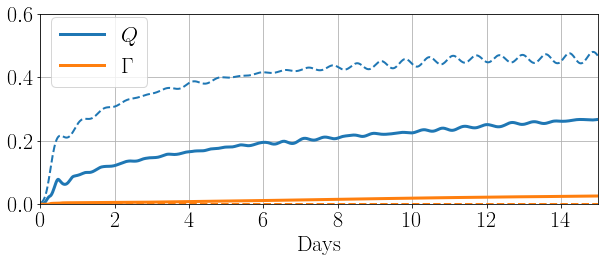

In [25]:
# Ratio of MPE to cumulative dissipation (include both mean and EKE dissipation)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.figure(figsize=(10,3.5))
plt.plot(time_d[startind:]/86400, -MPEI_d/DISSIT_d,linewidth=3, label='$Q$')
plt.plot(time[startind:]/86400, MPEI_g/EPSIT_g,linewidth=2,  linestyle='dashed', color='#1f77b4')
plt.plot(time_d[startind:]/86400, MIXI_d/DISSIT_d,linewidth=3, label='$\Gamma$')
plt.plot(time[startind:]/86400, EPSBIT_g/EPSIT_g,linewidth=2, linestyle='dashed', color='#ff7f0e')

# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
plt.ylim(-0.1,1)
plt.grid()
# plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.legend(bbox_to_anchor=(0., 0.56, 0.5, .062))

plt.xlabel('Days')
plt.xlim(0, 15)
plt.ylim(0, 0.6)

# plt.savefig('./MixingEfficiencies_1e-5_0p02.pdf', bbox_inches='tight')

(0, 0.06)

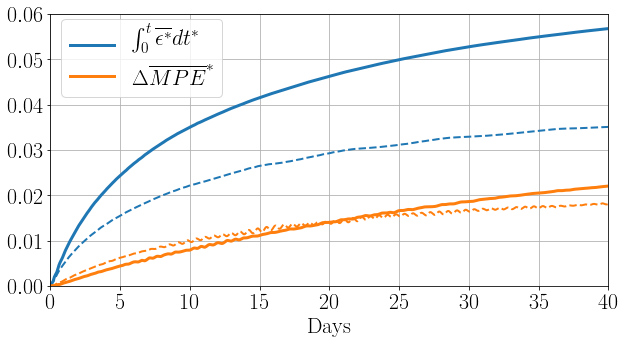

In [116]:
# Plot dissipation rates


norm = 0.1**3*1e4
plt.figure(figsize=(10,5))
plt.plot(time_d[startind:]/86400, -DISSIT_d/(norm),linewidth=3, label='$\int_0^t \overline{\epsilon^*} dt^*$')
plt.plot(time[startind:]/86400, EPSIT_g/(norm),linewidth=2,  linestyle='dashed', color='#1f77b4')
plt.plot(time_d[startind:]/86400, MPEI_d/norm,linewidth=3, label='$\Delta \overline{MPE}^*$')
plt.plot(time[startind:]/86400, MPEI_g/norm,linewidth=2, linestyle='dashed', color='#ff7f0e')
# plt.plot(time[startind:]/86400, 0.1**3*time/(10*1030))
# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
# plt.ylim(-0.1,1)
plt.grid()
plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.xlabel('Days')
plt.xlim(0, 40)
# plt.ylabel('$m^3s^{-2}$')
plt.ylim(0, 0.06)

# plt.savefig('./DISSMPE_1e-5_0p02.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0,0.5,'$m^3s^{-2}$')

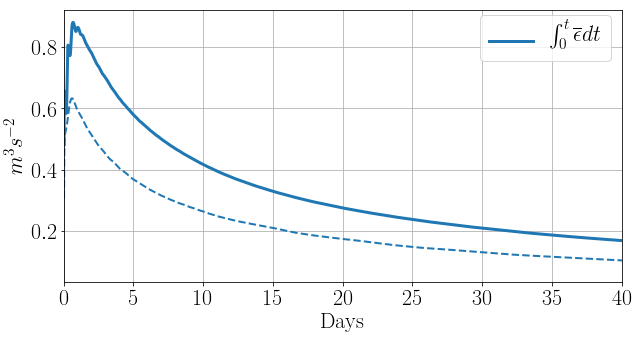

In [117]:
# Plot dissipation rates


norm = 0.1**3*1030**(-1)
plt.figure(figsize=(10,5))
plt.plot(time_d[startind:]/86400, -DISSIT_d/(norm*time_d),linewidth=3, label='$\int_0^t \overline{\epsilon} dt$')
plt.plot(time[startind:]/86400, EPSIT_g/(norm*time),linewidth=2,  linestyle='dashed', color='#1f77b4')
# plt.plot(time_d[startind:]/86400, MPEI_d/norm,linewidth=3, label='$\Delta \overline{MPE}$')
# plt.plot(time[startind:]/86400, MPEI_g/norm,linewidth=2, linestyle='dashed', color='#ff7f0e')
# plt.plot(time[startind:]/86400, 0.1**3*time/(10*1030))
# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
# plt.ylim(-0.1,1)
plt.grid()
plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.xlabel('Days')
plt.xlim(0, 40)
plt.ylabel('$m^3s^{-2}$')
# plt.ylim(0, 0.6)

# plt.savefig('./DISSMPE_1e-5_0p02.pdf', bbox_inches='tight')

In [ ]:
# Compare bottom drag